In [86]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
import seaborn as sns


# Function

In [87]:
def get_wind(u, v): 
    """"
    Calculates wind speed and direction from velocity components

    Parameters
    -----------
    u : np.Series
        The x wind component.
    v : np.Series  
        The y wind component. 

    Returns
    -------
    wind_speed : float
        Calculated wind speed.
    wind_dir : float
        Calculated wind direction.
    """
    u = u * units('m/s')
    v = v * units('m/s')

    wnd_spd = wind_speed(u,v)
    wnd_dir = wind_direction(u, v, convention='from')
    
    return wnd_spd, wnd_dir

def run_stats(df, var, site):
    """
    Calculates statistics comparing the observational data to the WRF data and returns as statistics in a dataframe.

    Statistics include: correlation, bias, root mean square error, and mean absolute error.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing the observed and modeled datasets.
    var : str
        Variable name to compute statistics for. 
    site : str
        Site to compute statistics for.

    Returns
    -------
    pd.DataFrame
        Dataframe of statistics for that site and variable. Includes the site and variable as fields. 

    """
    
    # Inner join
    df = pd.concat([xval, ymod], axis=1, join='inner')
    df.dropna(inplace=True)
    xval = df['val']
    ymod = df['model']
    
    # Calculate stats
    res = np.corrcoef(xval, ymod)
    corr = res[0,1]
    bias = (ymod - xval).mean()
    tmp = (ymod - xval)**2
    rmse = np.sqrt(tmp.mean())
    mabs = np.abs(ymod - xval).mean()
    # Return results
    results = { 
        'site' : [site],
        'variable' : [var],
        'correlation' : [round(corr, 2)],
        'bias' : [round(bias, 2)],
        'rmse' : [round(rmse, 2)],
        'mae' : [round(mabs, 2)]
    }
    
    df = pd.DataFrame(results)
    return df

def prep_wrf_data(fpath, site):
    """
    Reads and prepares WRF data

    Reads in data, convert temperature from K to C, casts index to DateTime format, calculates
    wind speed and direction, and returns the prepared dataframe

    Parameters
    ----------
    df_fpath : str
        Path to file containing the data.
    var_name_dict : dict
        Dictionary of variable rename mappings to.
    
    Returns
    -------
    pd.Dataframe
        The prepared dataframe. 
    """
    df = pd.read_pickle(fpath)
    df.index = df.index - pd.Timedelta(hours=8)  # UTC to local
    df = df.reset_index().rename({'times':'time (PST)'}, axis=1)
    wnd_spd, wnd_dir = get_wind(df['U10'].values, df['V10'].values)
    df['wind speed (m/s)'] = wnd_spd
    df['wind direction (deg)'] = wnd_dir
    df = df[['time (PST)', 'wind speed (m/s)', 'wind direction (deg)']]
    df.attrs['site'] = site
    df.attrs['source'] = 'wrf'

    df.set_index('time (PST)', inplace=True)
    
    return df

def prep_obs_data(fpath, site):
    """
    Reads and prepares WRF data

    Reads in data, convert temperature from K to C, casts index to DateTime format, calculates
    wind speed and direction, and returns the prepared dataframe

    Parameters
    ----------
    fpath : str
        Path to file containing the data.
    site : str 
        The site the data corresponds to.

    Returns
    -------
    pd.Dataframe
        The prepared dataframe. 
    """
    
    df = pd.read_csv(fpath, index_col='time (PST)')
    df.index = pd.to_datetime(df.index)
    df = df[['wind speed (m/s)', 'wind direction (deg)']]
    
    df.attrs['site'] = site
    df.attrs['source'] = 'observed'
    
    return df

def run_stats(df, var, source):
    """
    Calculates statistics comparing the observational data to the WRF data and returns as statistics in a dataframe.

    Statistics include: correlation, bias, root mean square error, and mean absolute error.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing the observed and modeled datasets.
    var : str
        Variable name to compute statistics for. 
    site : str
        Site to compute statistics for.

    Returns
    -------
    pd.DataFrame
        Dataframe of statistics for that site and variable. Includes the site and variable as fields. 

    """
    # Subset to source 
    df = df.loc[df['source'] == source]

    # Define validation/model data
    sauc = df.loc[df['site']=='Sauces Canyon'][var].rename('sauc')
    upem = df.loc[df['site']=='Upper Embudo Canyon'][var].rename('upem')
    
    # Inner join
    df = pd.concat([sauc, upem], axis=1, join='inner')
    df.dropna(inplace=True)
    sauc = df['sauc']
    upem = df['upem']
    
    # Calculate stats
    res = np.corrcoef(sauc, upem)
    corr = res[0,1]
    bias = (upem - sauc).mean()
    tmp = (upem - sauc)**2
    rmse = np.sqrt(tmp.mean())
    mabs = np.abs(upem - sauc).mean()
    # Return results
    results = { 
        'source' : [source],
        'variable' : [var],
        'correlation' : [round(corr, 2)],
        'bias' : [round(bias, 2)],
        'rmse' : [round(rmse, 2)],
        'mae' : [round(mabs, 2)]
    }
    
    df = pd.DataFrame(results)
    return df

def plot_stats(stats_df, metric, height=8, aspect=1):
    """
    Plot bar charts for the supplied metric, broken down by variable and site. 

    Parameters
    ----------
    stats_df : pd.DataFrame
        Dataframe of statistics for each site/variable.
    metric : {'correlation', 'bias', 'rmse', 'mae'}
        Metric to plot.
    
    Returns
    -------
        None
    """
    g = sns.catplot(
        data=stats_df, kind="bar",
        x="variable", y=metric, hue='source',
        palette="tab10", alpha=.6, height=height,
        aspect=aspect
    )
    g.set_axis_labels("", metric)

    g.legend.set_title("")
    g.set(title=metric)
    plt.show()

def plot_timeseries(df, var, daterange, source):
    """
    Plot timeseries lineplot for given variable, daterange, and site.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of observational and WRF data.
    var_list : list of str
        List of variables to plot for.
    daterange : list of str
        Date range to subset data to. Should be in the form [From, To], or ['YYYY-MM-DD','YYYY-MM-DD'].
    site : str
        Site to plot for. 
    
    Returns
    -------
        None
    """
    df = df.loc[df['source']==source]
    sauc = df.loc[df['site'] == 'Sauces Canyon']
    upem = df.loc[df['site'] == 'Upper Embudo Canyon']
    
    sauc = sauc[daterange[0] : daterange[1]]
    upem = upem[daterange[0] : daterange[1]]
    
    year = daterange[0].split('-')[0]
    month = daterange[0].split('-')[1]

    fig, ax = plt.subplots(figsize=(20,6))
    
    
    ax.plot(sauc.index, sauc[var], color='blue', label=f'SAUC {var}')
    ax.plot(upem.index, upem[var], color='orange', label=f'UPEM {var}')

    fig.legend(loc='upper right', bbox_to_anchor=(1.10, .99), bbox_transform=ax.transAxes)

    ax.set(title=f'Sauces vs. Upper Embudo {var}\n {source} {month}/{year}',
           ylabel=f'{var}')

    plt.show()

In [88]:
root_dir = Path().resolve().parent
obs_data_dir = root_dir / 'data' / 'observational' / 'aggregated-datasets'
wrf_data_dir = root_dir / 'data' / 'wrf-extracted' / 'single-pixel'

osauc_fname = 'sauc-hourly.csv'
oupem_fname = 'upem-hourly.csv'
wsauc_fname = 'wrf-sauc-2003-2010.pkl'
wupem_fname = 'wrf-upem-2003-2010.pkl'


osauc_fpath =  obs_data_dir / osauc_fname
oupem_fpath = obs_data_dir / oupem_fname
wsauc_fpath = wrf_data_dir / wsauc_fname
wupem_fpath = wrf_data_dir / wupem_fname

osauc_df = prep_obs_data(osauc_fpath, 'Sauces Canyon')
oupem_df = prep_obs_data(oupem_fpath, 'Upper Embudo Canyon')
wsauc_df = prep_wrf_data(wsauc_fpath, "Sauces Canyon")
wupem_df = prep_wrf_data(wupem_fpath, "Upper Embudo Canyon")

wupem_df.head(2)

,wind speed (m/s),wind direction (deg)
time (PST),,
2002-06-30 16:00:00,3.036855,218.233735
2002-06-30 17:00:00,0.736050,190.393139


In [89]:
# Join all into a single dataframe
df_list = [wsauc_df, wupem_df, osauc_df, oupem_df]
for df in df_list:
    df['site'] = df.attrs['site']
    df['source'] = df.attrs['source']

df = pd.concat(df_list, join='inner', axis=0)
df.head(2)

,wind speed (m/s),wind direction (deg),site,source
time (PST),,,,
2002-06-30 16:00:00,3.002108,218.612980,Sauces Canyon,wrf
2002-06-30 17:00:00,0.134169,118.507522,Sauces Canyon,wrf


# Comparison Statistics

In [90]:
variables = ['wind speed (m/s)', 'wind direction (deg)']
sources = ['wrf', 'observed']

stats_df = pd.DataFrame()
for source in sources:
    for variable in variables:
        tmp = run_stats(df, variable, source)
        stats_df = pd.concat([stats_df, tmp], axis=0)

stats_df

,source,variable,correlation,bias,rmse,mae
0,wrf,wind speed (m/s),0.94,-0.19,0.94,0.72
0,wrf,wind direction (deg),0.80,-12.82,65.19,26.16
0,observed,wind speed (m/s),0.62,-0.37,1.31,0.99
0,observed,wind direction (deg),0.53,8.34,104.81,69.75


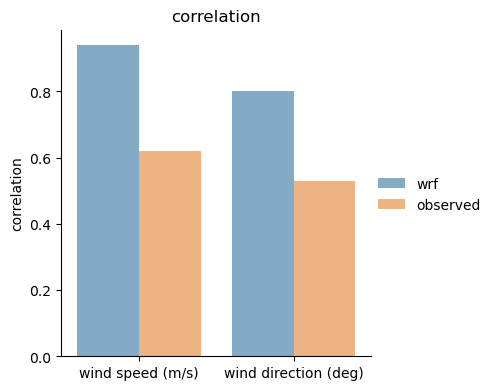

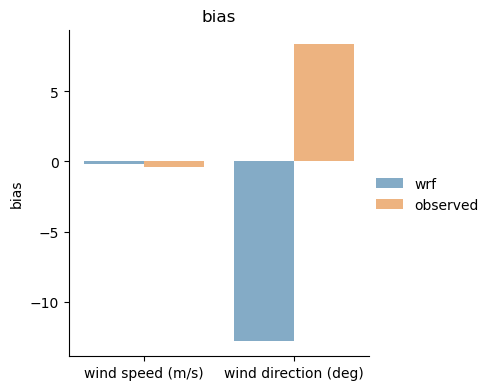

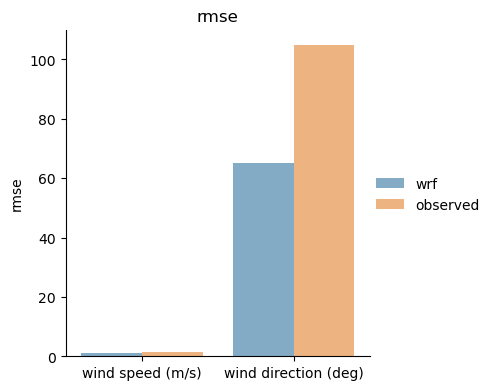

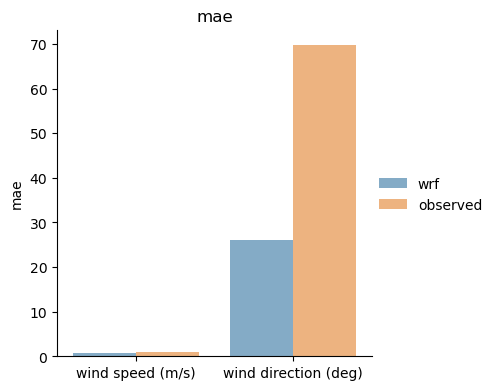

In [91]:
for metric in ['correlation', 'bias', 'rmse', 'mae']:
    plot_stats(stats_df, metric, height=4)

# Plots

## Wind Speed

### Observed Data

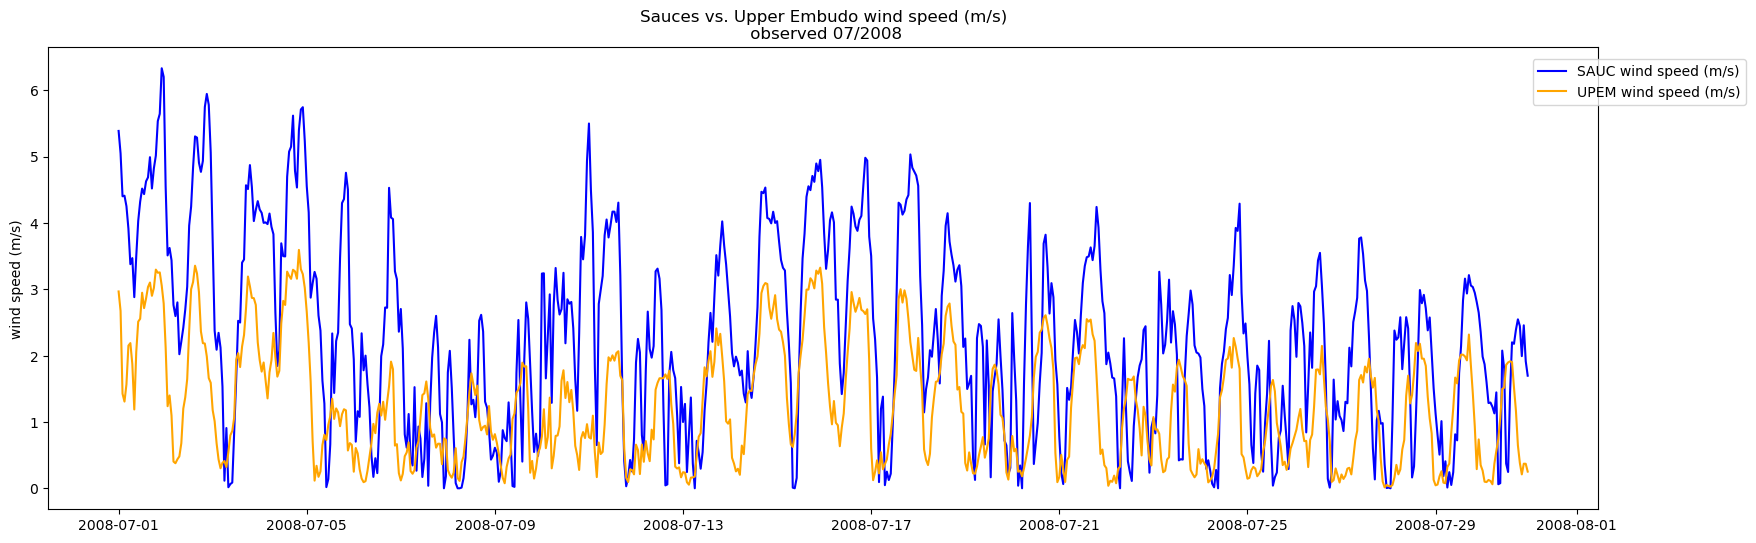

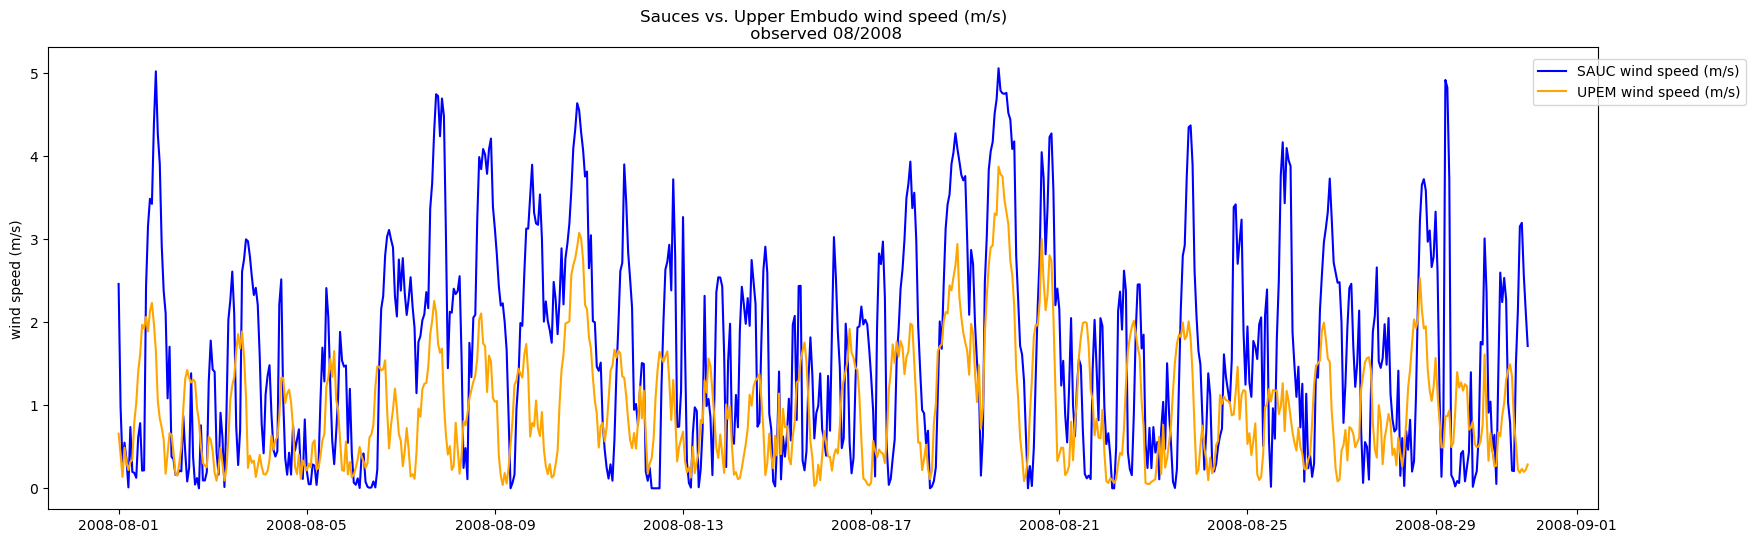

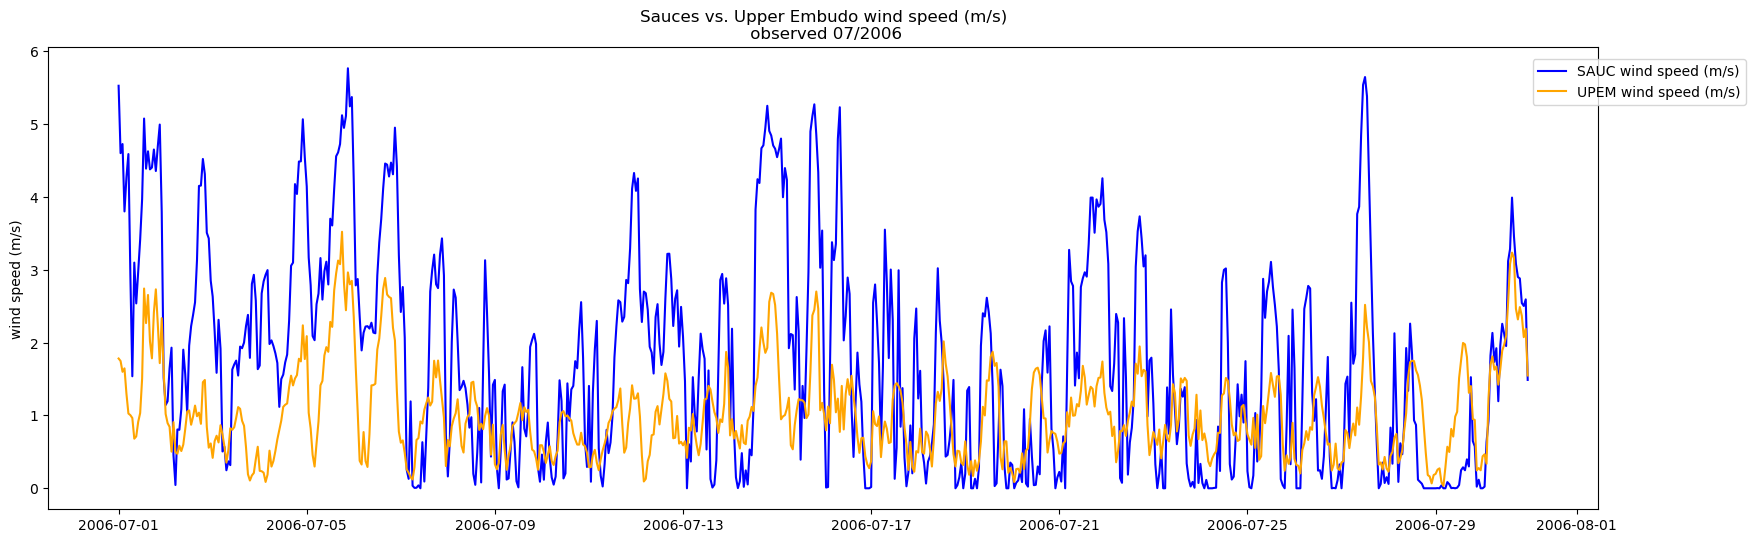

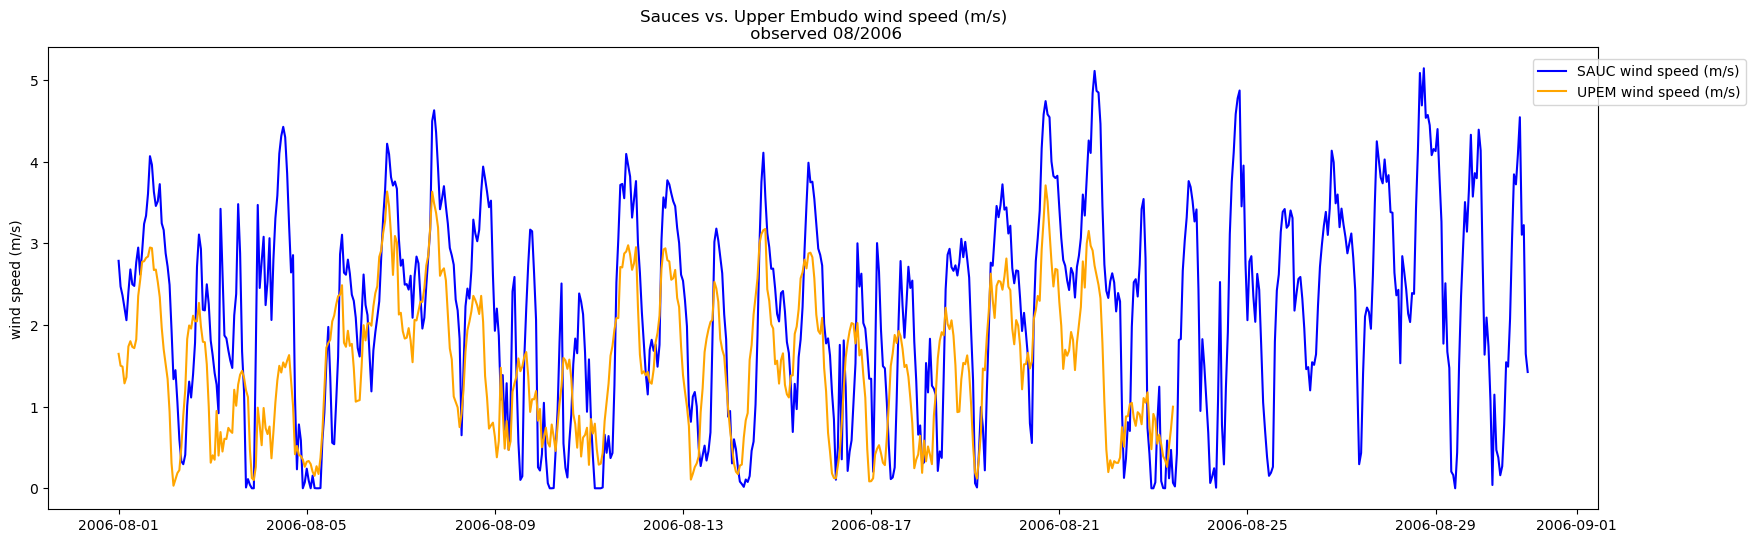

In [92]:
dateranges = [['2008-07-01', '2008-07-30'],
              ['2008-08-01', '2008-08-30'],
              ['2006-07-01', '2006-07-30'],
              ['2006-08-01', '2006-08-30']]
for daterange in dateranges:
    plot_timeseries(df, 'wind speed (m/s)', daterange=daterange, source='observed') 

### WRF Data

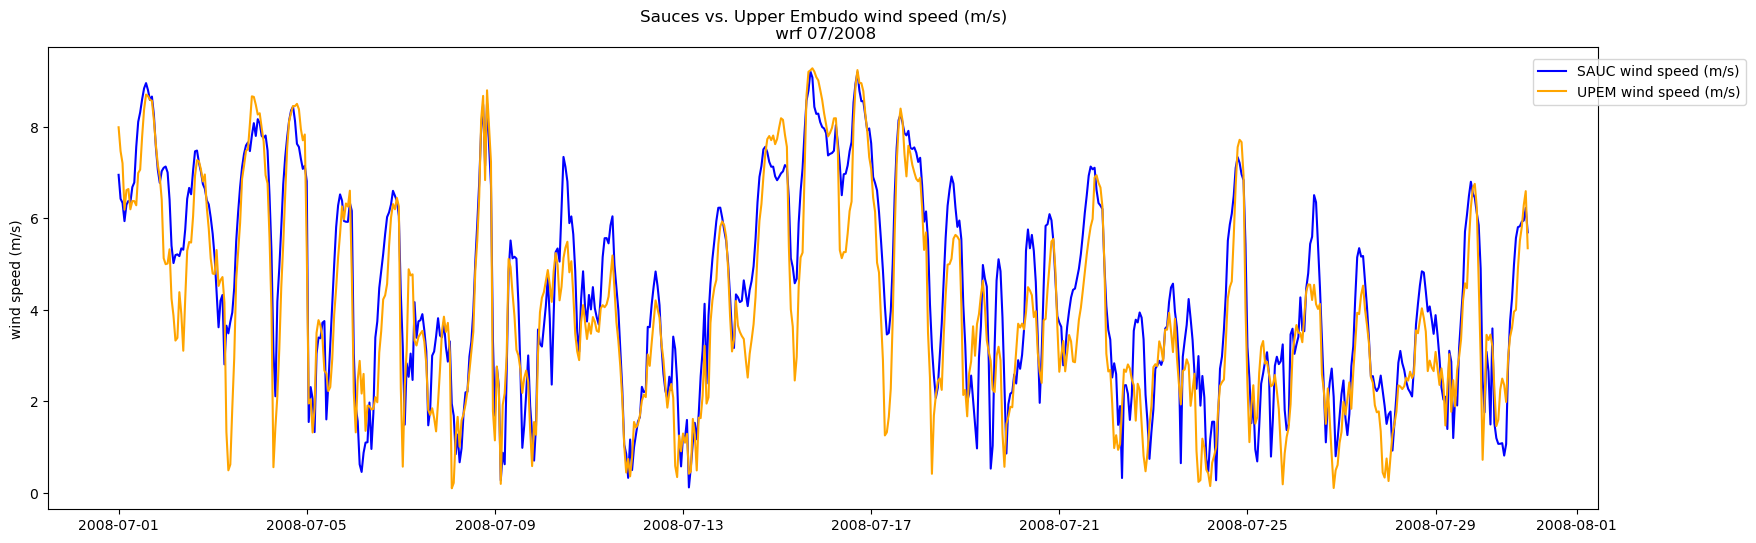

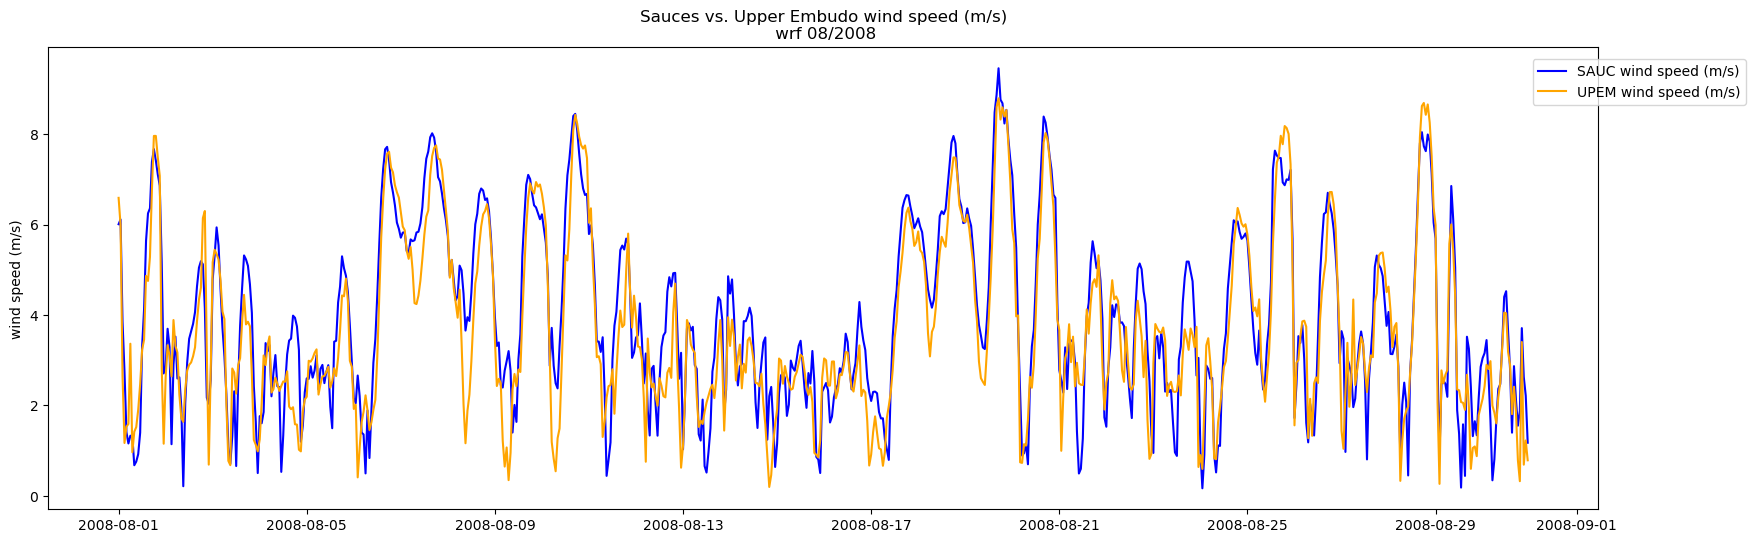

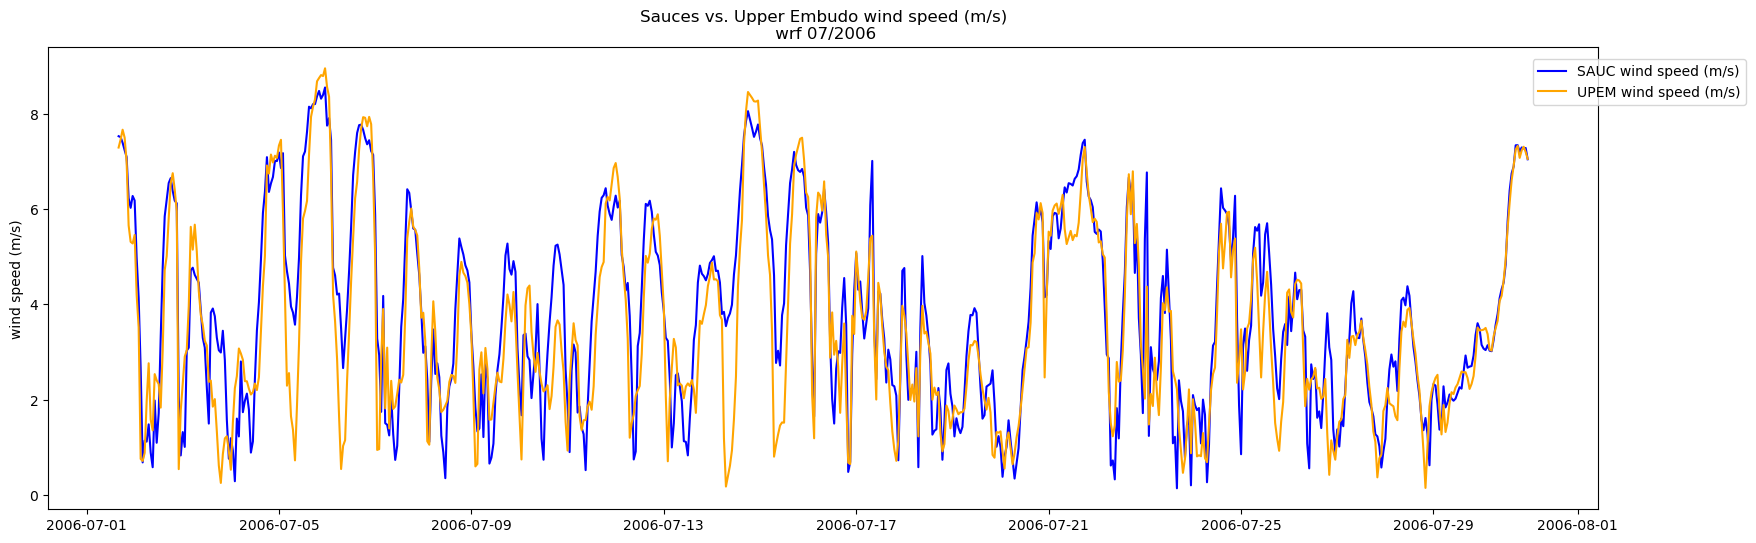

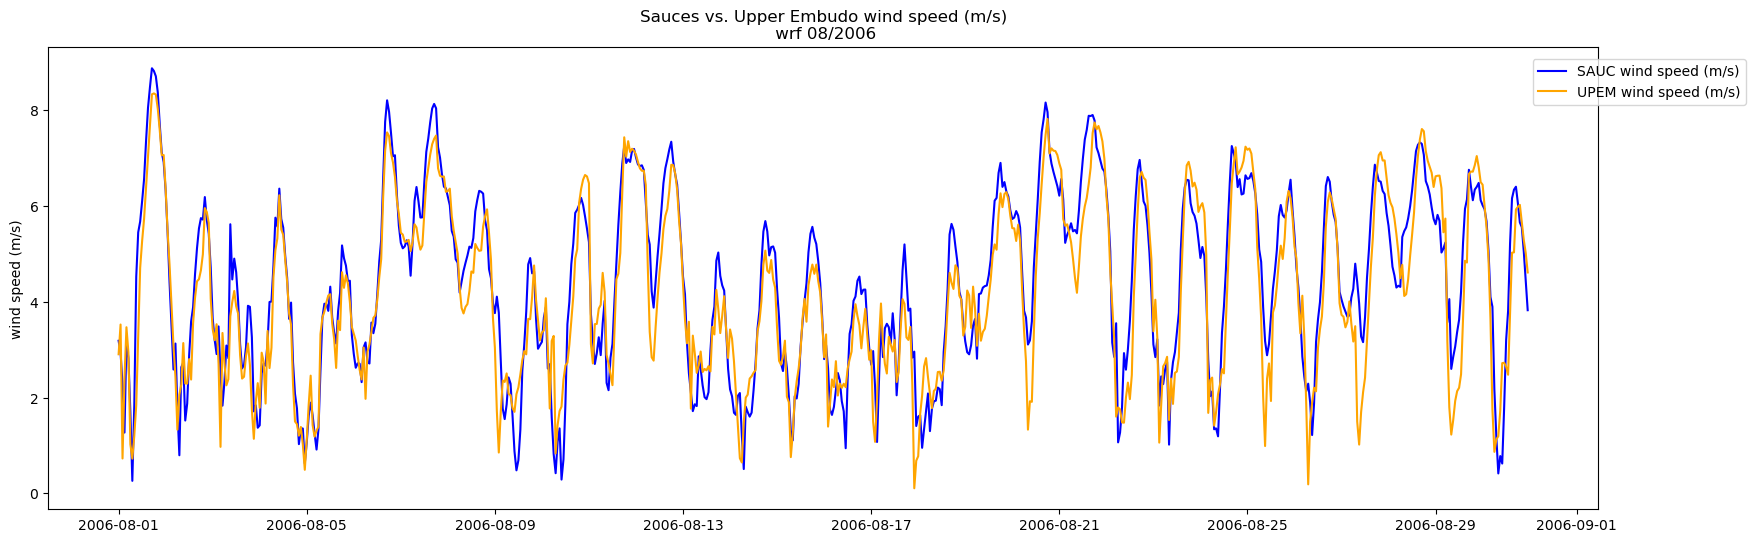

In [93]:
dateranges = [['2008-07-01', '2008-07-30'],
              ['2008-08-01', '2008-08-30'],
              ['2006-07-01', '2006-07-30'],
              ['2006-08-01', '2006-08-30']]
for daterange in dateranges:
    plot_timeseries(df, 'wind speed (m/s)', daterange=daterange, source='wrf') 

## Wind Direction

### Observed

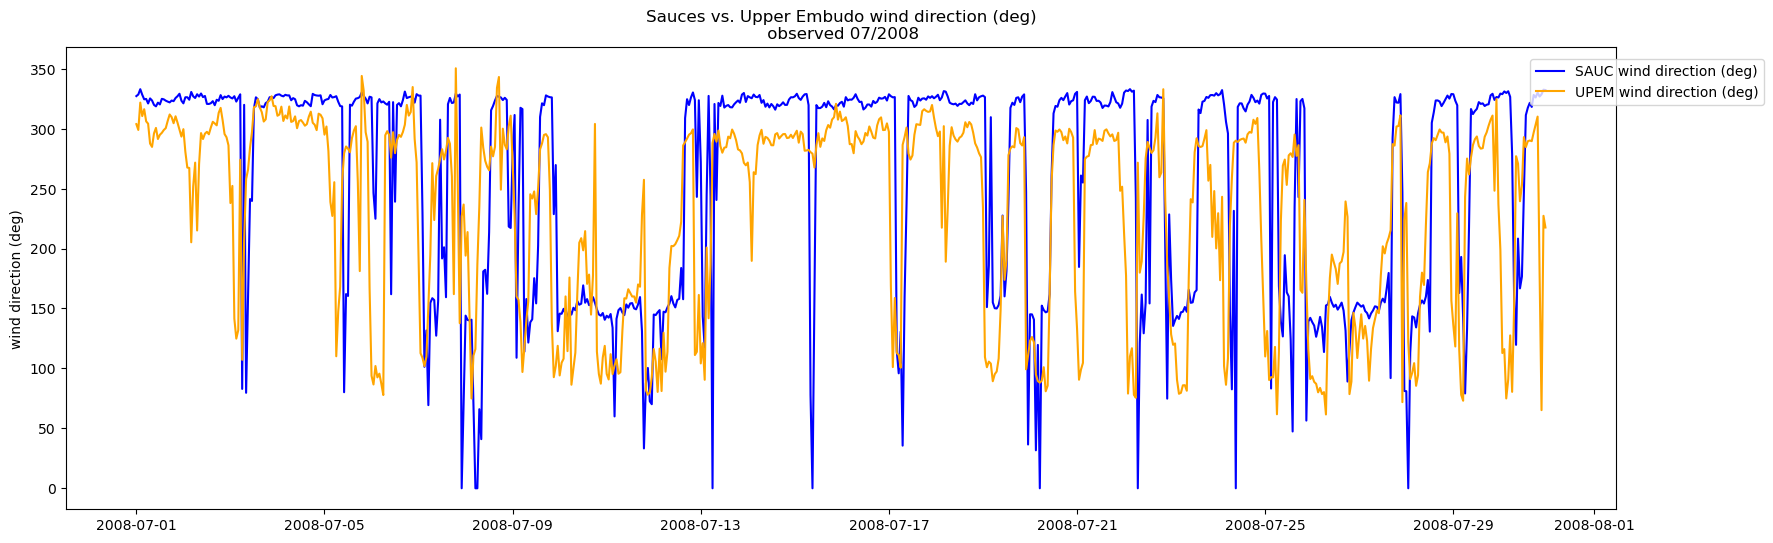

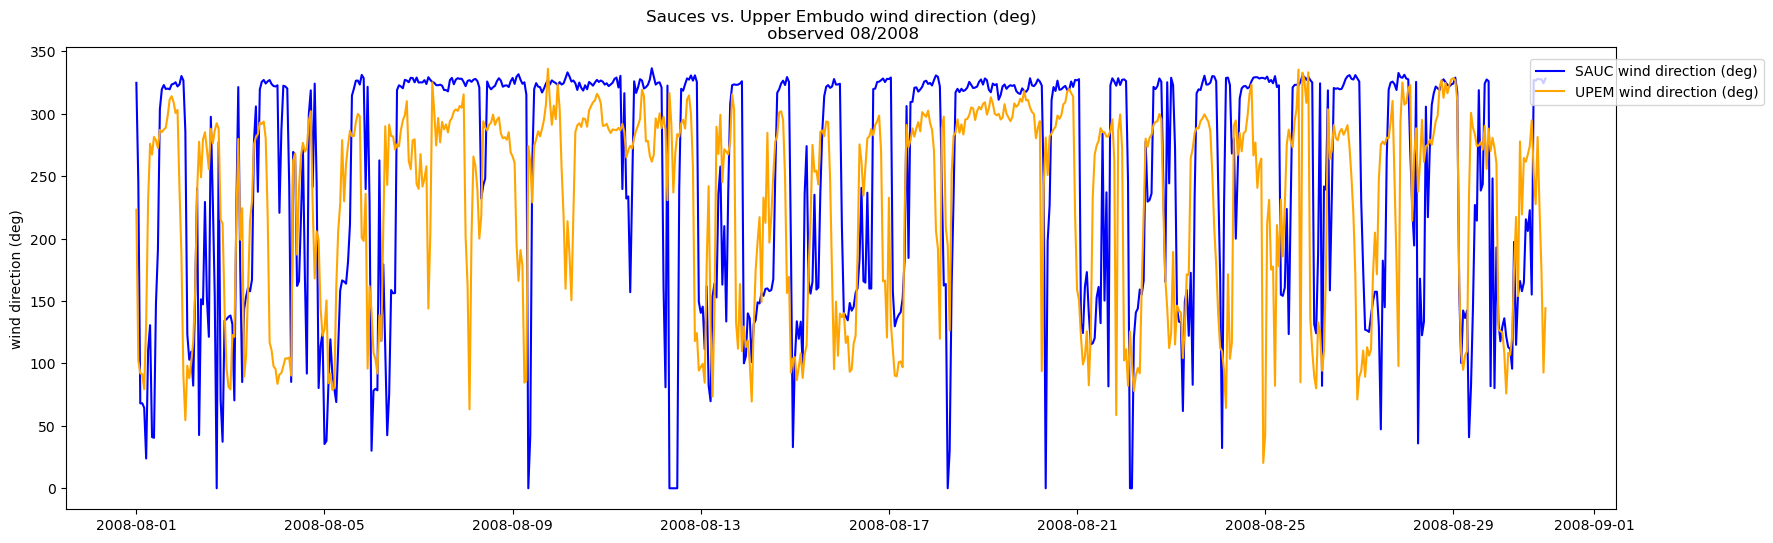

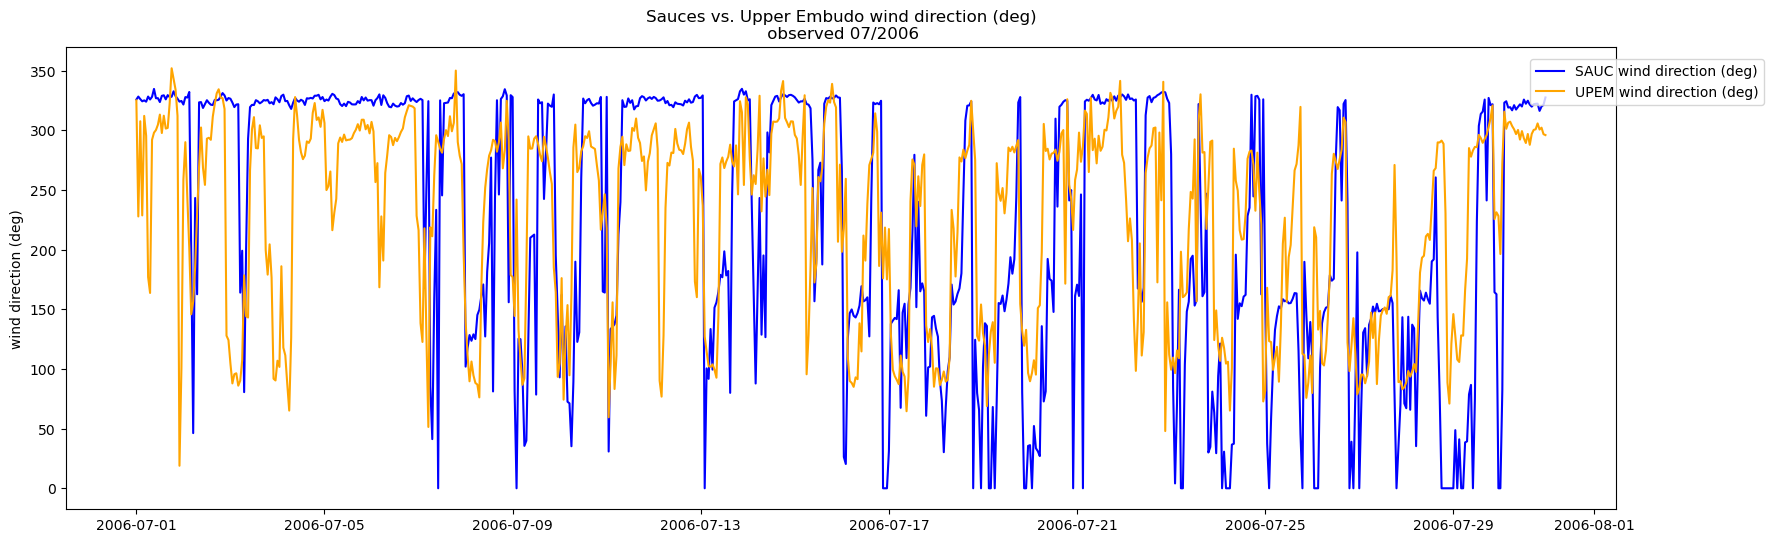

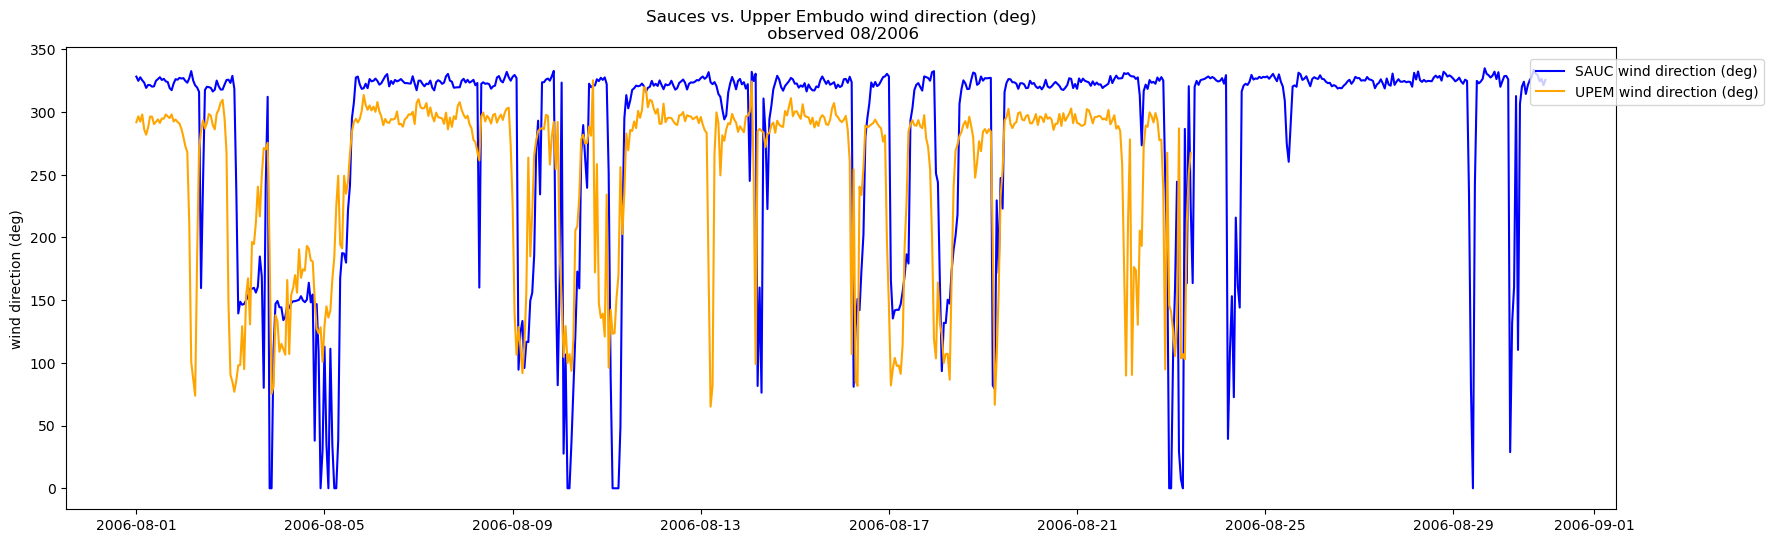

In [94]:
dateranges = [['2008-07-01', '2008-07-30'],
              ['2008-08-01', '2008-08-30'],
              ['2006-07-01', '2006-07-30'],
              ['2006-08-01', '2006-08-30']]
for daterange in dateranges:
    plot_timeseries(df, 'wind direction (deg)', daterange=daterange, source='observed')

### WRF

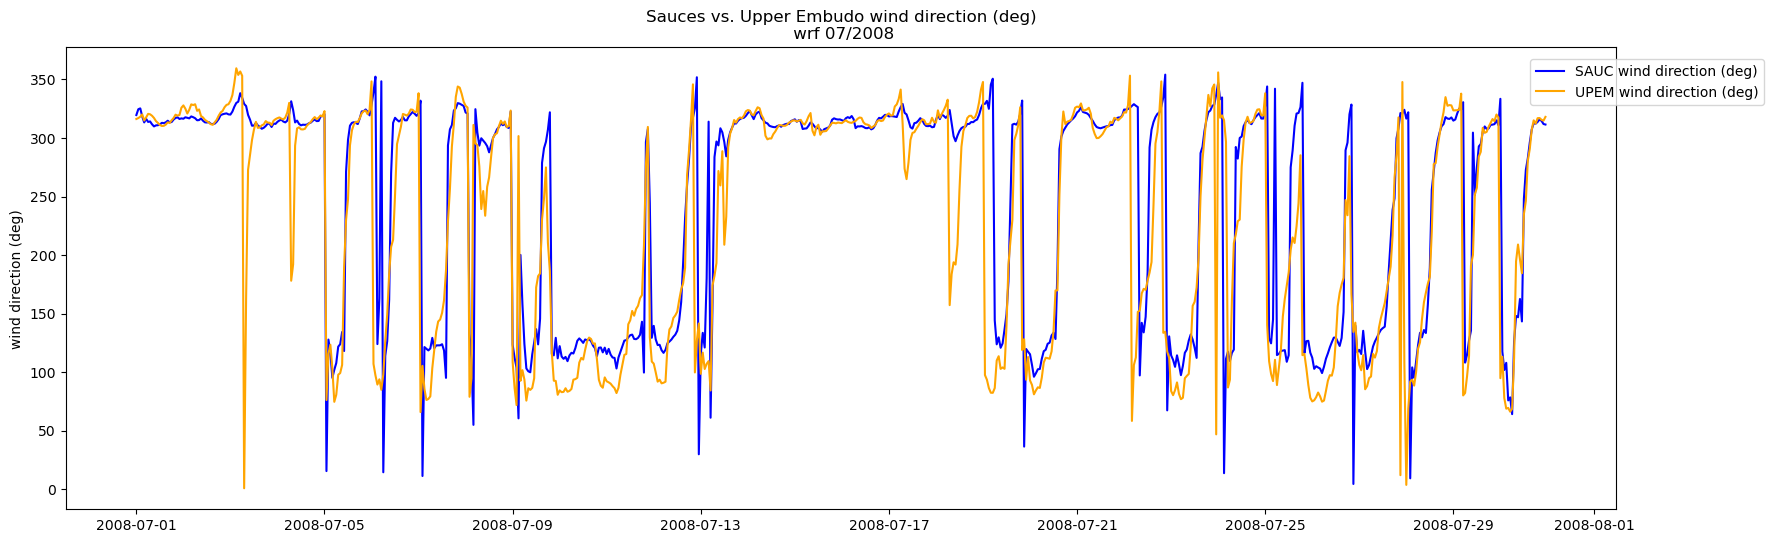

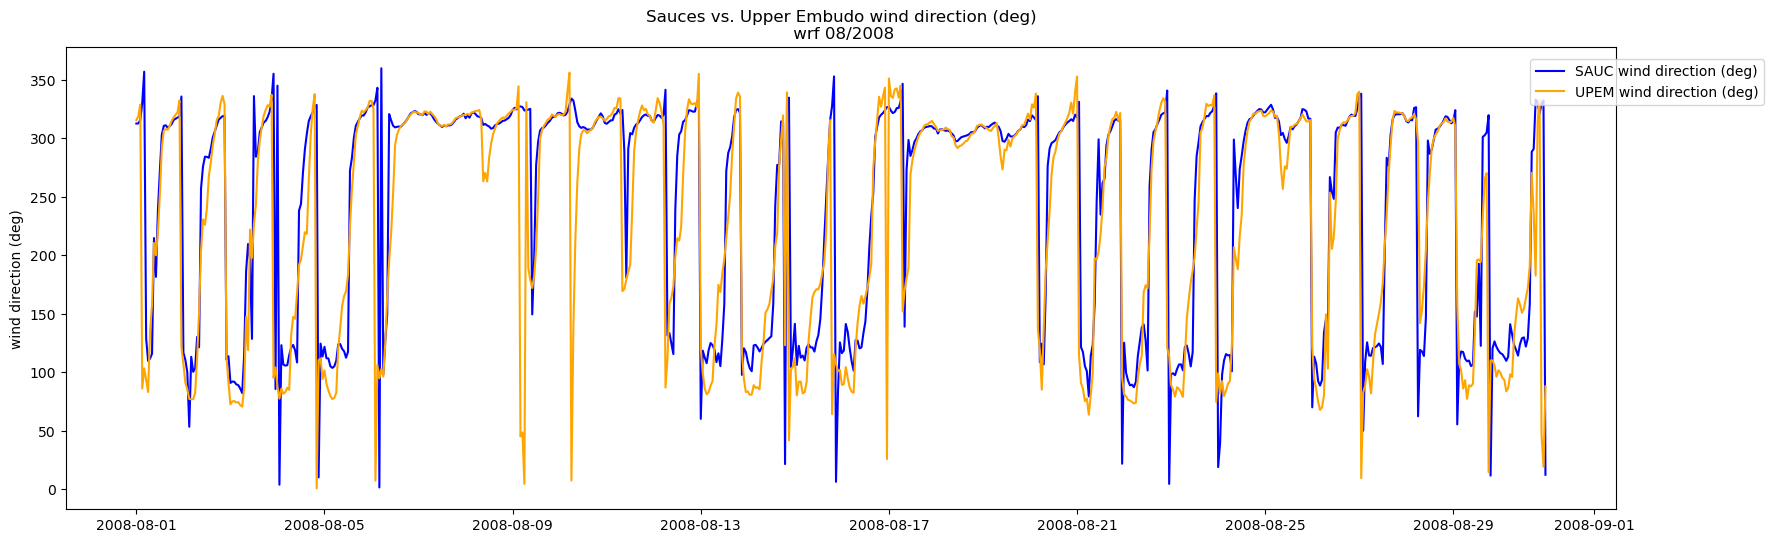

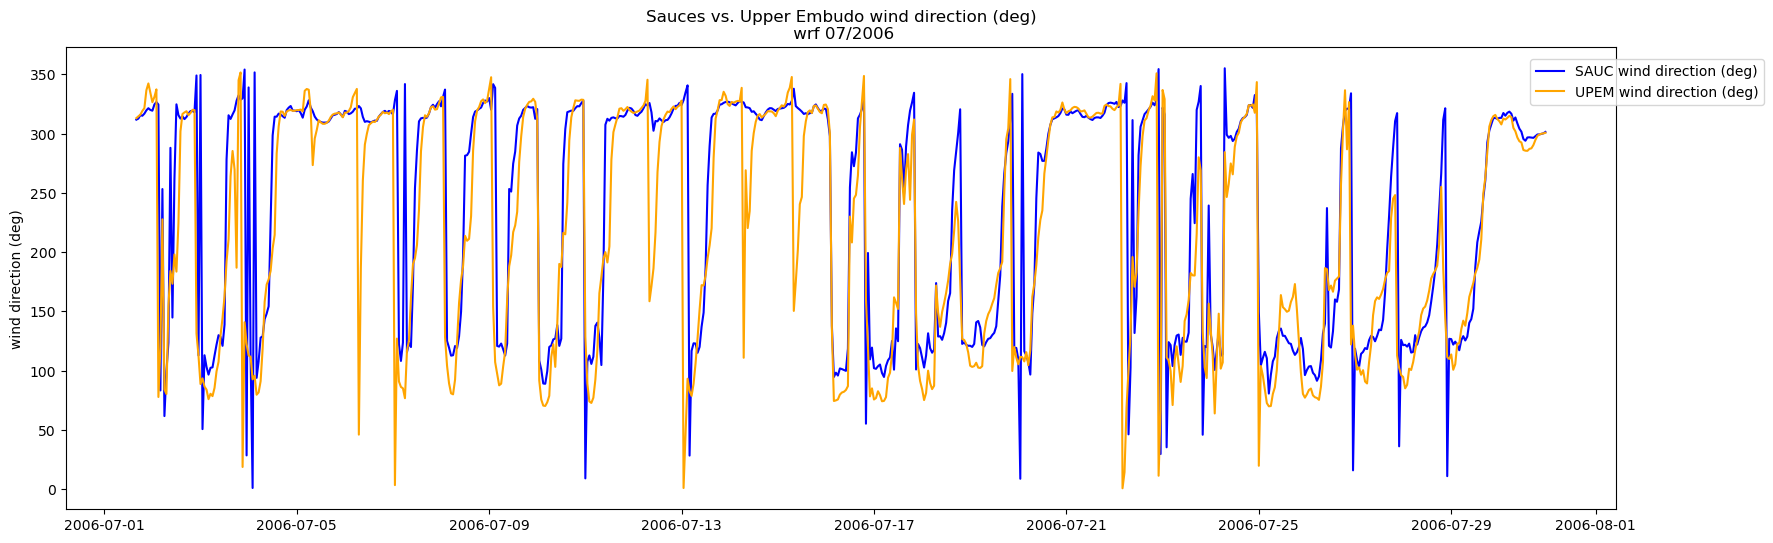

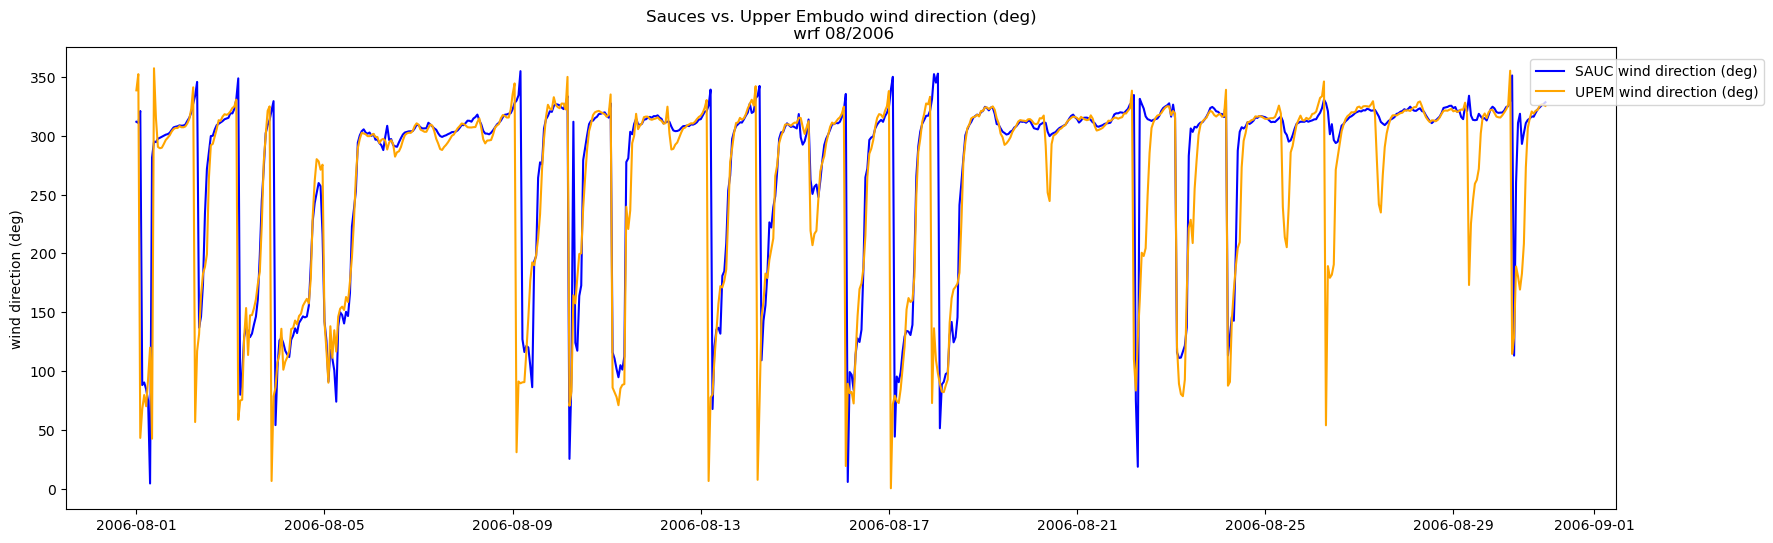

In [95]:
dateranges = [['2008-07-01', '2008-07-30'],
              ['2008-08-01', '2008-08-30'],
              ['2006-07-01', '2006-07-30'],
              ['2006-08-01', '2006-08-30']]
for daterange in dateranges:
    plot_timeseries(df, 'wind direction (deg)', daterange=daterange, source='wrf') 